In [2]:
pip install scikit-learn==1.0.2

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install -U imbalanced-learn==0.9.1

Note: you may need to restart the kernel to use updated packages.


In [65]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


# Task2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from pyarrow.csv import read_csv
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import sklearn.svm as svm
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

전처리 방법: 주말과 주중의 평균을 각각 이용



In [2]:
X = read_csv('X_model_nnew.csv').to_pandas()
X = X.iloc[:,1:]
y = read_csv('Y_model.csv').to_pandas()
X.fillna(0, inplace=True)
X2 = read_csv('X_model_new.csv').to_pandas()
y = read_csv('Y_model.csv').to_pandas()
for i in range(8):
    X2[f's{i+1}'] = X2[f's{i+1}']**0.1

In [3]:
X = pd.concat((X.drop(columns=['s_week_mean', 's_weekend_mean']),X2.loc[:,'s1':'s8']), axis=1)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle = True, 
                                                    random_state = 42, test_size=0.25) 

In [5]:
X_train

,gender,age_code,region_code,c_week_mean,c_weekend_mean,t_week_mean,t_weekend_mean,s1,s2,s3,s4,s5,s6,s7,s8
86425,1,8,14,2.335294,1.205882,0.729412,0.647059,2.304368,2.238701,2.302285,2.189161,2.204921,2.242983,2.256462,2.110946
449602,2,10,1,0.994118,0.323529,0.270588,0.088235,2.355360,2.361867,2.374334,2.377278,2.437972,2.367704,2.393201,2.305022
230293,1,3,5,0.176471,0.029412,0.005882,0.000000,0.000000,0.000000,0.000000,2.100379,2.155986,1.937903,1.743803,0.000000
587952,2,11,13,0.005882,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.837162,0.000000,0.000000,0.000000
27942,1,11,4,0.082353,0.029412,0.000000,0.000000,0.000000,0.000000,0.000000,2.058322,1.669287,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,1,4,1,0.570588,0.617647,0.094118,0.147059,1.894313,2.087988,1.765366,1.872171,1.931318,1.892072,1.872525,1.899035
365838,1,6,15,0.664706,0.382353,0.288235,0.235294,1.929437,2.210300,1.993459,2.284630,1.920341,1.894949,2.007301,1.840490
131932,2,7,1,0.635294,0.382353,0.141176,0.088235,1.925075,1.867519,1.808852,2.044009,2.194810,2.069792,1.965623,2.104120
671155,1,4,1,0.052941,0.088235,0.017647,0.058824,0.000000,0.000000,0.000000,1.414214,0.000000,0.000000,1.991641,1.739050


In [6]:
predict_probas = []

for j in range(5,6):
    model = XGBClassifier(n_estimators=150, learning_rate=0.2, max_depth=5, random_state = 42, 
                          predictor='gpu_predictor',  tree_method = 'gpu_hist',gpu_id=0, 
                          scale_pos_weight=13, max_delta_step=5)
    #model = LGBMClassifier(boosting_type='gbdt', n_estimators=150, max_depth=6, learning_rate=0.2, 
    #                       gpu_use_dp=True, gpu_device_id=0, scale_pos_weight=i, boost_from_average=False,
    #                       device_type='cpu', pos_bagging_fraction=0.9, neg_bagging_fraction=1, 
    #                       subsample_freq=500,
    #                       lambdarank_norm=True)
    model.fit(X_train, y_train.values.ravel())
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    predict_probas.append(y_pred_proba[:,1])
    print(confusion_matrix(y_test, y_pred))
    acc = accuracy_score(y_test, y_pred)
    print('accuracy_score : ',acc)

    pre = precision_score(y_test, y_pred)
    print('precision_score : ', pre)

    recall = recall_score(y_test, y_pred)
    print('recall_score: ', recall)

    roc = roc_auc_score(y_test, y_pred_proba[:,1])
    print('auc roc score: ', roc)
    
    x=0
    for k in range(len(y_pred)):
        if y_pred[k]==1:
            x+=1
                
    print('scale_pos_weight= ', i)
    print('max_delta_step= ', j)
    print('Expected income= ', (5000*x*pre-400*x))
    print('----------------------------------------')

[[136732  50158]
 [  1448  11662]]
accuracy_score :  0.74197
precision_score :  0.18864445163377547
recall_score:  0.8895499618611746
auc roc score:  0.8831028931183551
scale_pos_weight=  7
max_delta_step=  5
Expected income=  33582000.0
----------------------------------------


In [7]:
predict_probas = []
model = XGBClassifier(n_estimators=150, learning_rate=0.2, max_depth=5, random_state = 42, 
                          predictor='gpu_predictor',  tree_method = 'gpu_hist',gpu_id=0, 
                          scale_pos_weight=1, max_delta_step=1)
    #model = LGBMClassifier(boosting_type='gbdt', n_estimators=150, max_depth=6, learning_rate=0.2, 
    #                       gpu_use_dp=True, gpu_device_id=0, scale_pos_weight=i, boost_from_average=False,
    #                       device_type='cpu', pos_bagging_fraction=0.9, neg_bagging_fraction=1, 
    #                       subsample_freq=500,
    #                       lambdarank_norm=True)
model.fit(X_train, y_train.values.ravel())
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

In [8]:
#task2
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])
expected_incomes = []
fpr_incomes = []
thre_incomes = []
for i in tqdm(range(1,len(thresholds), 100)):
    y_predict_for_income = [0]*len(thresholds)
    for j in range(len(y_pred_proba)):
        if y_pred_proba[:,1][j] >= thresholds[i]:
            y_pred[j] = 1
        else:
            y_pred[j] = 0
    x=0
    for k in range(len(y_pred)):
        if y_pred[k]==1:
            x+=1
    pre = precision_score(y_test, y_pred)
    expected_incomes.append(5000*x*pre-400*x)
    fpr_incomes.append(fpr[i])
    thre_incomes.append(thresholds[i])

  7%|█████▍                                                                           | 21/311 [00:03<00:51,  5.63it/s]


KeyboardInterrupt: 

In [9]:
#task 3
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])
expected_incomes_t3 = []
fpr_incomes_t3 = []
thre_incomes_t3 = []
pre_t3 = []
xxx = []
for i in tqdm(range(1,len(thresholds), 100)):
    y_predict_for_income = [0]*len(thresholds)
    for j in range(len(y_pred_proba)):
        if y_pred_proba[:,1][j] >= thresholds[i]:
            y_pred[j] = 1
        else:
            y_pred[j] = 0
    x=0
    for k in range(len(y_pred)):
        if y_pred[k]==1:
            x+=1
    xxx.append(x)
    pre = precision_score(y_test, y_pred)
    pre_t3.append(pre)
    expected_incomes_t3.append((18000*x*pre-900*x))
    fpr_incomes_t3.append(fpr[i])
    thre_incomes_t3.append(thresholds[i])

100%|████████████████████████████████████████████████████████████████████████████████| 311/311 [00:58<00:00,  5.36it/s]


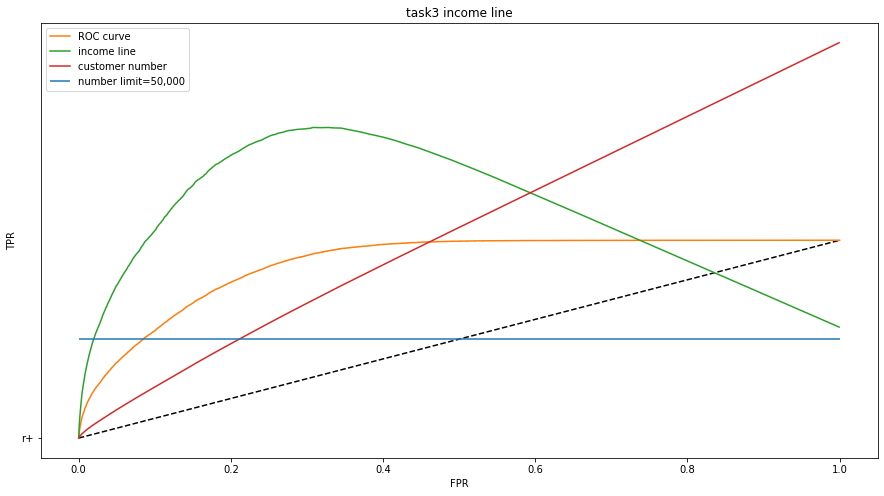

precision =  0.2114348653249224
Optimal threshold =  0.10442571
Expected income =  145102500.0
customer number =  49935


In [10]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])
plt.figure(figsize=(15,8))
plt.plot([0,1], [0,1], "k--", "r+")
plt.plot(fpr, tpr, label='ROC curve')
plt.plot(fpr_incomes_t3, np.array(expected_incomes_t3)*0.00000001, label='income line')
plt.plot(fpr_incomes_t3, np.array(xxx)*0.00001, label='customer number')
plt.hlines(y=50000*0.00001, xmin=0, xmax=1, label='number limit=50,000')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('task3 income line')
plt.legend()
plt.show()
optimal_thre = thre_incomes_t3[np.where(np.array(xxx)<=50000)[-1][-1]]
print('precision = ', pre_t3[np.where(np.array(xxx)<=50000)[-1][-1]])
print('Optimal threshold = ', optimal_thre)
print('Expected income = ', expected_incomes_t3[np.where(np.array(xxx)<=50000)[-1][-1]])
print('customer number = ', xxx[np.where(np.array(xxx)<=50000)[-1][-1]])

# task3

In [11]:
X_task3 = read_csv('X_new_task3.csv').to_pandas().iloc[:, 1:]
y_task3 = read_csv('y_model_task3.csv').to_pandas()

In [12]:
X_train_task3, X_test_task3, y_train_task3, y_test_task3 = train_test_split(X_task3, y_task3, 
                                                            shuffle = True, 
                                                            random_state = 42, test_size=0.25) 

In [42]:
predict_probas_task3 = []
for i in range(1,25):
    model_task3 = XGBClassifier(n_estimators=150, learning_rate=0.2, max_depth=5, random_state = 42, 
                          predictor='gpu_predictor',  tree_method = 'gpu_hist',gpu_id=0, 
                          scale_pos_weight=i, max_delta_step=1)
    #model = LGBMClassifier(boosting_type='gbdt', n_estimators=150, max_depth=6, learning_rate=0.2, 
    #                       gpu_use_dp=True, gpu_device_id=0, scale_pos_weight=0.01*i, boost_from_average=False,
    #                       device_type='cpu', pos_bagging_fraction=0.9, neg_bagging_fraction=1, 
    #                       subsample_freq=500,
    #                       lambdarank_norm=True)
    model_task3.fit(X_train_task3, y_train_task3.values.ravel())
    y_pred_task3 = model_task3.predict(X_test_task3)
    y_pred_proba_task3 = model_task3.predict_proba(X_test_task3)
    predict_probas_task3.append(y_pred_proba_task3[:,1])
    print(confusion_matrix(y_test_task3, y_pred_task3))
    acc = accuracy_score(y_test_task3, y_pred_task3)
    print('accuracy_score : ',acc)

    pre = precision_score(y_test_task3, y_pred_task3)
    print('precision_score : ', pre)

    recall = recall_score(y_test_task3, y_pred_task3)
    print('recall_score: ', recall)

    roc = roc_auc_score(y_test_task3, y_pred_proba_task3[:,1])
    print('auc roc score: ', roc)
    
    x=0
    for k in range(len(y_pred_task3)):
        if y_pred[k]==1:
            x+=1
                
    sb_come_proba = y_pred_proba_task3[:,1] * y_pred_proba[:,1]
    quat75 = np.quantile(sb_come_proba, 0.75)
    pred3 = np.where(sb_come_proba>quat75,1,0)
    print('scale_pos_weight = ', i)
    print('# of SBO = ', confusion_matrix(y_test, pred3)[1,1])
    print('----------------------------------------')

[[92197 16381]
 [19747 71675]]
accuracy_score :  0.81936
precision_score :  0.8139706550377033
recall_score:  0.7840016626195008
auc roc score:  0.8999707024323919
scale_pos_weight =  1
# of SBO =  10196
----------------------------------------
[[80934 27644]
 [11956 79466]]
accuracy_score :  0.802
precision_score :  0.741910185790309
recall_score:  0.8692218503204918
auc roc score:  0.8994078662162182
scale_pos_weight =  2
# of SBO =  10383
----------------------------------------
[[71769 36809]
 [ 7352 84070]]
accuracy_score :  0.779195
precision_score :  0.6954888773070591
recall_score:  0.9195817199361204
auc roc score:  0.8998403058975137
scale_pos_weight =  3
# of SBO =  10438
----------------------------------------
[[65473 43105]
 [ 5459 85963]]
accuracy_score :  0.75718
precision_score :  0.6660287600334708
recall_score:  0.9402878956925029
auc roc score:  0.9000912438512728
scale_pos_weight =  4
# of SBO =  10501
----------------------------------------
[[60104 48474]
 [ 4378

In [29]:
X_train_task3

,gender,age_code,region_code,c1,c2,c3,c4,c5,c6,c7,...,s7,s8,t1,t2,t3,t4,t5,t6,t7,t8
86425,1,8,14,83.0,67.0,86.0,55.0,49.0,42.0,42.0,...,3422.0,1412.0,17.0,18.0,23.0,13.0,24.0,20.0,20.0,12.0
449602,2,10,1,27.0,16.0,28.0,21.0,36.0,26.0,27.0,...,6163.0,3401.0,6.0,7.0,7.0,4.0,11.0,7.0,4.0,4.0
230293,1,3,5,0.0,0.0,0.0,7.0,15.0,9.0,1.0,...,260.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
587952,2,11,13,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27942,1,11,4,0.0,0.0,0.0,11.0,8.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,1,4,1,14.0,20.0,17.0,10.0,9.0,44.0,13.0,...,530.0,610.0,6.0,2.0,2.0,1.0,4.0,6.0,2.0,0.0
365838,1,6,15,8.0,12.0,17.0,38.0,13.0,14.0,15.0,...,1062.0,172.0,3.0,6.0,9.0,17.0,7.0,7.0,5.0,2.0
131932,2,7,1,12.0,15.0,15.0,15.0,21.0,23.0,14.0,...,861.0,936.0,2.0,2.0,3.0,2.0,5.0,7.0,3.0,3.0
671155,1,4,1,0.0,0.0,0.0,3.0,0.0,0.0,6.0,...,982.0,250.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0


In [22]:
sb_come_proba = y_pred_proba_task3[:,1] * y_pred_proba[:,1]
quat75 = np.quantile(sb_come_proba, 0.75)
pred3 = np.where(sb_come_proba>quat75,1,0)

In [45]:
print(confusion_matrix(y_test, pred3))
acc = accuracy_score(y_test, pred3)
print('accuracy_score : ',acc)

pre = precision_score(y_test, pred3)
print('precision_score : ', pre)

recall = recall_score(y_test, pred3)
print('recall_score: ', recall)

roc = roc_auc_score(y_test, y_pred_proba_task3[:,1])
print('auc roc score: ', roc)

[[147458  39432]
 [  2542  10568]]
accuracy_score :  0.79013
precision_score :  0.21136
recall_score:  0.8061022120518688
auc roc score:  0.7837018606253168


In [44]:
confusion_matrix(y_test, pred3)

array([[147458,  39432],
       [  2542,  10568]], dtype=int64)